In [2]:
import sys
import os

from matplotlib import pyplot as plt
# from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import math
import sys
import logging
from io import StringIO 
import re
from arg_parse import *
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import contextlib

logging.getLogger('matplotlib.font_manager').disabled = True

import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

In [57]:
fig_loc = "figures/"

In [4]:
sys.path.append(os.getcwd()+"/Sklearn-neat")

import neat
from neat import math_util
from neat.puissance import Puissance 

from neuro_evolution import NEATClassifier

In [33]:
args.population_size = 10
args.fitness_limit = 0.75
args.generations = 8

In [34]:
root = logging.getLogger()
root.setLevel(logging.DEBUG)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [35]:
# class Capturing(list):
#     def __enter__(self):
#         self._stdout = sys.stdout
#         sys.stdout = self._stringio = open('output.txt','wt')
#         return self
#     def __exit__(self, *args):
#         self.extend(self._stringio.getvalue().splitlines())
#         print(self)

#         del self._stringio    # free up some memory
#         sys.stdout = self._stdout

In [36]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

X = np.append(x_train,x_test).reshape(60000,32,32,3)
y = np.append(y_train,y_test).reshape(60000,1)

assert X.shape == (60000, 32, 32, 3)
assert y.shape == (60000, 1)

In [37]:
#Preprocess the data
X = X.astype('float32')
X /= 255

In [38]:
sss = StratifiedShuffleSplit(n_splits=5, 
                             train_size=args.train_size, 
                             test_size=args.test_size,
                             random_state=0)

for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
print(X_train.shape)
print(y_train.shape)

print("---")

print(X_test.shape)
print(y_test.shape)

(12, 32, 32, 3)
(12, 1)
---
(12, 32, 32, 3)
(12, 1)


In [39]:
def find_metric_in_output(output, string):    
    result = re.findall(r"\b"+string+r" ([0-9]+\.[0-9]+)\b", str(output))
    
    result = np.array(result).astype('float')
        
    return result 

In [40]:
def find_puissance_in_output(output):    
    result = re.findall(r"\b(?<=Unique puissance values: {).*?(?=})\b", str(output))    
    return result 

In [41]:
X_train_fl = X_train.reshape((X_train.shape[0], -1))
X_test_fl = X_test.reshape((X_test.shape[0], -1))

try:
    puissance_config = Puissance()

    clf = NEATClassifier(number_of_generations=args.generations,
                         fitness_threshold=args.fitness_limit,
                         pop_size=args.population_size,
                         puissance_config = puissance_config)
    
    logging.info("Running NEAT puissance")
    
except:
    clf = NEATClassifier(number_of_generations=args.generations,
                         fitness_threshold=args.fitness_limit,
                         pop_size=args.population_size)
    
    logging.info("Running NEAT")

2021-06-08 20:06:00,977 - root - INFO - Running NEAT puissance
2021-06-08 20:06:00,977 - root - INFO - Running NEAT puissance


In [43]:
# for i in range(3):
#     logging.info("*** Running generation "+str(i)+" ***")

path = 'output.txt'
with open(path, 'w') as f:
    with contextlib.redirect_stdout(f):
        neat_genome = clf.fit(X_train_fl, y_train.ravel())
# sys.stdout.close()
        
#     curr_fitness = find_metric_in_output(output, "Fitness:")
#     curr_popavgfit = find_metric_in_output(output, "Population's average f3itness:")
#     curr_stdev = find_metric_in_output(output, "stdev:")
        
#     print("Fitness: {}".format(curr_fitness))
#     print("Population's average fitness: {}".format(curr_popavgfit))
#     print("Standard deviation: {}".format(curr_stdev))

#     print("---")
#     if curr_fitness > best_fitness:
#         best_fitness = curr_fitness
        
#     print("Best fitness: {}".format(best_fitness))
    
    
# #     print(output)
#     print(output)
    
#     results[i] = {
#         "fitness":curr_fitness,
#         "pop_avg_fitness":curr_popavgfit,
#         "stdev":curr_stdev   
#     }

#     print("---\n")

In [44]:
output = open("output.txt", "r").read()

In [45]:
gen_time = find_metric_in_output(output, "Generation time:")
cum_gen_time = np.array([])

for i in range(1,len(gen_time)+1):
    cum_gen_time = np.append(cum_gen_time, gen_time[:i].sum())
    
print(gen_time)
print(cum_gen_time)

[10.747 11.536 11.787 11.422 11.811 11.341 11.63  11.597]
[10.747 22.283 34.07  45.492 57.303 68.644 80.274 91.871]


In [46]:
results = {}

results['best_fitness'] = find_metric_in_output(output, "Best fitness:")
results['avg_adj_fitness'] = find_metric_in_output(output, "Average adjusted fitness:")
results['pop_avg_fitness'] = find_metric_in_output(output, "Population's average fitness:")
results['gen_time'] = gen_time
results['cum_gen_time'] = cum_gen_time
results['stdev'] = find_metric_in_output(output, "stdev:")
# metrics['puissance'] = puissance = find_puissance_in_output(output)

assert len(results['best_fitness']) == \
        len(results['avg_adj_fitness']) == \
        len(results['pop_avg_fitness']) == \
        len(results['gen_time']) == \
        len(results['stdev'])

In [47]:
print(results)

{'best_fitness': array([0.16667, 0.16667, 0.16667, 0.16667, 0.16667, 0.16667, 0.16667,
       0.16667]), 'avg_adj_fitness': array([0.075, 0.117, 0.117, 0.042, 0.058, 0.05 , 0.058, 0.058]), 'pop_avg_fitness': array([0.075  , 0.11667, 0.11667, 0.125  , 0.14167, 0.13333, 0.14167,
       0.14167]), 'gen_time': array([10.747, 11.536, 11.787, 11.422, 11.811, 11.341, 11.63 , 11.597]), 'cum_gen_time': array([10.747, 22.283, 34.07 , 45.492, 57.303, 68.644, 80.274, 91.871]), 'stdev': array([0.05833, 0.05528, 0.05528, 0.04167, 0.03819, 0.04082, 0.03819,
       0.03819])}


In [48]:
y_pred = neat_genome.predict(X_test_fl)
    
print(classification_report(y_test.ravel(), y_pred.ravel()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.12      1.00      0.22         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.08        12
   macro avg       0.01      0.10      0.02        12
weighted avg       0.01      0.08      0.02        12



/home/sram/radboud-naco-project/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sram/radboud-naco-project/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sram/radboud-naco-project/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [49]:
# puissance_config = Puissance()

# clf = NEATClassifier(number_of_generations=3,
#                      fitness_threshold=0.5,
#                      pop_size=5,
#                      puissance_config = puissance_config)

In [50]:
# for i in range(args.generations):
#     logging.info("*** Running generation "+str(i)+" ***")
#     with Capturing() as output:
#         neat_genome = clf.fit(X_train_fl, y_train.ravel())
        
#     curr_fitness = find_metric_in_output(output, "Fitness:")
#     curr_popavgfit = find_metric_in_output(output, "Population's average fitness:")
#     curr_stdev = find_metric_in_output(output, "stdev:")
        
#     print("Fitness: {}".format(curr_fitness))
#     print("Population's average fitness: {}".format(curr_popavgfit))
#     print("Standard deviation: {}".format(curr_stdev))

#     print("---")
#     if curr_fitness > best_fitness:
#         best_fitness = curr_fitness
        
#     print("Best fitness: {}".format(best_fitness))
    
#     print(find_metric_in_output(output, "Generation time:"))
    
#     results[i] = {
#         "fitness":curr_fitness,
#         "pop_avg_fitness":curr_popavgfit,
#         "stdev":curr_stdev   
#     }

#     print("---\n")

In [51]:
np.linspace(1,args.generations,args.generations)

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [52]:
def plot_results(plots, xlabel, ylabel, fig_name):
    fig,ax = plt.subplots(figsize=(15,8))

    for i in range(0,len(plots)):
        plt.plot(plots[i]['x'],
                 plots[i]['y'],
                 label = plots[i]['label'])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()

    plt.xticks(np.arange(0, args.generations, math.ceil(args.generations/100)))

    plt.savefig(fig_loc+fig_name)

    plt.plot()

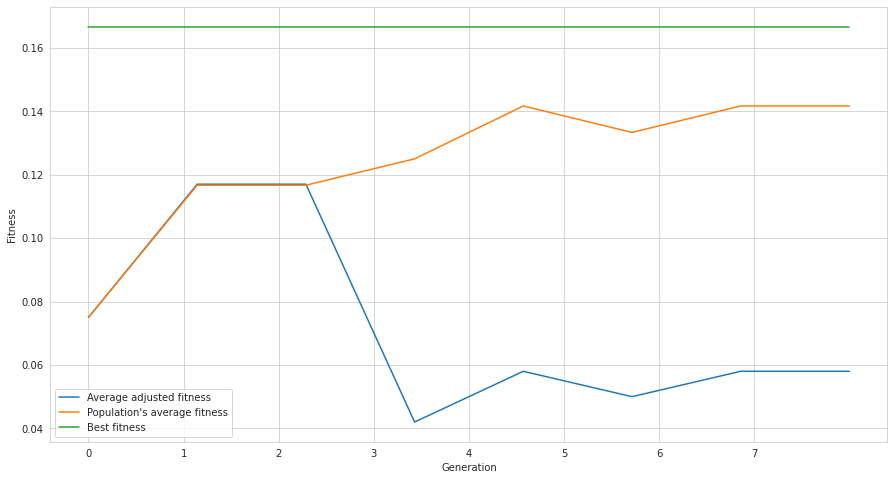

In [53]:
plots = {}

plots[0] = {
    "x":np.linspace(0,args.generations,args.generations),
    "y":results['avg_adj_fitness'],
    "label":"Average adjusted fitness"
}

plots[1] = {
    "x":np.linspace(0,args.generations,args.generations),
    "y":results['pop_avg_fitness'],
    "label":"Population's average fitness"  
}

plots[2] = {
    "x":np.linspace(0,args.generations,args.generations),
    "y":results['best_fitness'],
    "label":"Best fitness"  
}

plot_results(plots, "Generation", "Fitness", "fitness.png")

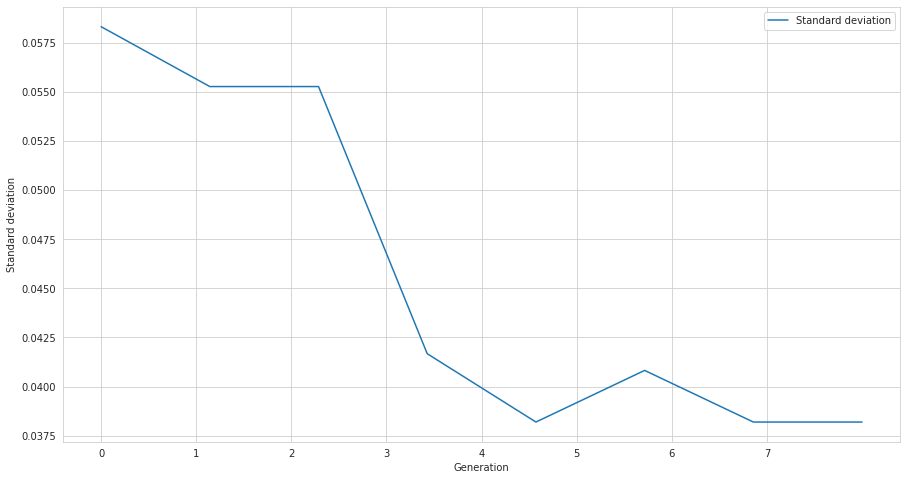

In [54]:
plots = {}

plots[0] = {
    "x":np.linspace(0,args.generations,args.generations),
    "y":results['stdev'],
    "label":"Standard deviation"
}

plot_results(plots, "Generation", "Standard deviation", "stdev.png")

In [ ]:
plots = {}

plots[0] = {
    "x":np.linspace(0,args.generations,args.generations),
    "y":results['gen_time'],
    "label":"Generation time"
}

plot_results(plots, "Generation", "Generation time", "gen_time.png")

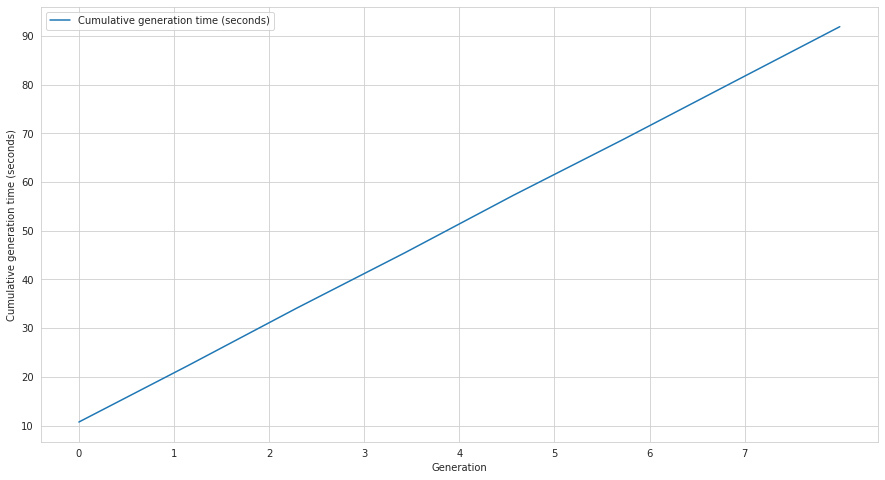

In [56]:
plots = {}

plots[0] = {
    "x":np.linspace(0,args.generations,args.generations),
    "y":results['cum_gen_time'],
    "label":"Cumulative generation time (seconds)"
}

plot_results(plots, "Generation", "Cumulative generation time (seconds)", "cum_gen_time.png")